In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Fri May 27 07:35:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# [Part 1] image feature extraction. 

mahotas library 사용 방법  
https://pinkwink.kr/1173

In [ ]:
!pip install mahotas

     |████████████████████████████████| 5.7 MB 5.2 MB/s 


In [ ]:
import cv2 #Opencv
from google.colab.patches import cv2_imshow
import os
import numpy as np
import sklearn
from glob import glob
import mahotas as mh
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

In [ ]:
images = glob('/content/drive/MyDrive/mapping/hermione_granger_human.jpeg')
images.extend(glob('/content/drive/MyDrive/mapping/*.webp'))
images[:]

['/content/drive/MyDrive/mapping/hermione_granger_human.jpeg',
 '/content/drive/MyDrive/mapping/hermione_granger.webp',
 '/content/drive/MyDrive/mapping/draco_malfoy.webp',
 '/content/drive/MyDrive/mapping/severus_snape.webp',
 '/content/drive/MyDrive/mapping/harry_potter.webp']

In [ ]:
im = mh.imread(images[0])
im = mh.colors.rgb2gray(im, dtype=np.uint8)

In [ ]:
def chist(im):
    """Compute color histograms of input image
    Parameters
    ----------------------
    im  :  ndarray
            should be an RGB image
    Returns
    ---------------
    c  :  ndarray
           1-D array of histogram values
    """    
    # Downsample pixel values
    im = im//64
    # We can also implement the following by using np.histogramdd
    # im = im.reshape((-1, 3))
    # bins = [ np.arange(5),  np.arange(5),  np.arange(5) ]
    # hist = np.histogramdd( im, bins=bins )[0]
    # hist = hist.ravel()
    
    # Separate RGB channels
    r, g, b = im.transpose( (2, 0, 1) )
    
    pixels = 1*r + 4*g + 16*b
    hist = np.bincount( pixels.ravel(), minlength=64 )
    hist = hist.astype(float)
    return np.log1p(hist)    

In [ ]:
features = []
for im in images:
    imcolor = mh.imread(im)
    imcolor = imcolor[50:-50, 50:-50] #이미지의 외곽선에 가까운 값 처리하기
    im = mh.colors.rgb2gray(imcolor, dtype=np.uint8)
    features.append(np.concatenate([mh.features.haralick(im).ravel(), chist(imcolor),])) #haralick

In [ ]:
imcolor

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[ 31,  31,  33],
        [  7,   7,   9],
        [  9,   9,  11],
        ...,
        [146, 148, 152],
        [150, 151, 155],
        [157, 158, 162]],

       [[ 28,  28,  30],
        [  3,   3,   6],
        [ 16,  16,  18],
        ...,
        [144, 146, 150],
        [150, 151, 155],
        [158, 160, 164]],

       [[ 21,  21,  23],
        [  2,   2,   4],
        [ 30,  30,  32],
        ...,
        [139, 141, 145],
        [145, 147, 151],
        [156, 157, 161]]

In [ ]:
sc = MinMaxScaler()
features = sc.fit_transform(features)

In [ ]:
from scipy.spatial  import distance
dists = distance.squareform(distance.pdist(features))

In [ ]:
dists

array([[0.        , 4.56689447, 7.18205066, 5.98298277, 5.48068519],
       [4.56689447, 0.        , 6.04930779, 4.17576346, 3.51416518],
       [7.18205066, 6.04930779, 0.        , 5.59247198, 5.6577394 ],
       [5.98298277, 4.17576346, 5.59247198, 0.        , 3.24586585],
       [5.48068519, 3.51416518, 5.6577394 , 3.24586585, 0.        ]])

In [ ]:
def selectImage( n, m, dists, images):
    image_position = dists[n].argsort()[m]
    image = mh.imread(images[image_position])
    return image

In [ ]:
#이미지 plot 영역
def plotImages(n):
    plt.figure(figsize=(15, 15))
    
    plt.subplot(141)
    plt.imshow(selectImage(n, 0, dists, images))
    plt.title('Original')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(142)
    plt.imshow(selectImage(n, 1, dists, images))
    plt.title('1st similar one')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(143)
    plt.imshow(selectImage(n, 2, dists, images))
    plt.title('2nd similar one')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(144)
    plt.imshow(selectImage(n, 3, dists, images))
    plt.title('3rd similar one')
    plt.xticks([])
    plt.yticks([])
    
    plt.show()

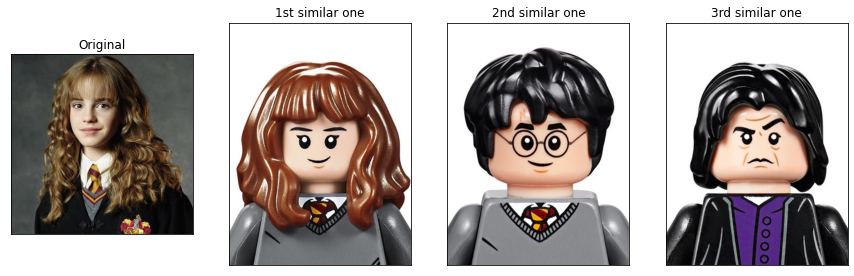

In [ ]:
plotImages(0)

관련 알고리즘 SIFT  
https://bkshin.tistory.com/entry/OpenCV-28-%ED%8A%B9%EC%A7%95-%EB%A7%A4%EC%B9%ADFeature-Matching 

# [Part 2] image modeling

In [ ]:
import cv2 #Opencv
from google.colab.patches import cv2_imshow
import os
import numpy as np
import sklearn
from glob import glob
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

In [ ]:
"""
images = list()
images.extend(glob('/content/drive/MyDrive/harry_potter/*.jpg'))
"""

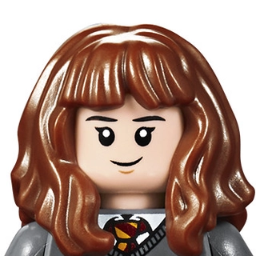

(427, 320, 3) (256, 256, 3)


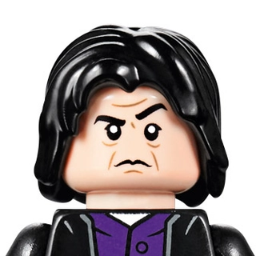

(427, 320, 3) (256, 256, 3)


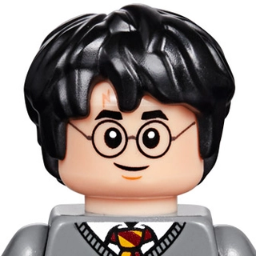

(427, 320, 3) (256, 256, 3)


In [ ]:
"""
cnt = 1
for url in images:
  src = cv2.imread(url, cv2.IMREAD_COLOR)
  dst = src[40:-67, :].copy()

  resize_img = cv2.resize(dst, (256, 256 ))
  cv2_imshow(resize_img)
  print(src.shape, resize_img.shape)
  cv2.imwrite(url, resize_img)
  cnt += 1
"""

In [ ]:
if os.path.isdir('/content/drive/MyDrive/WIP/stylegan2-ada/'):
    %cd '/content/drive/MyDrive/WIP/stylegan2-ada/'
else:
    !git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git /content/drive/MyDrive/WIP/stylegan2-ada/
    %cd '/content/drive/MyDrive/WIP/stylegan2-ada/'

/content/drive/MyDrive/WIP/stylegan2


In [ ]:
!python dataset_tool.py \
--source=/content/drive/MyDrive/lego_mugshots \
--dest=/content/drive/MyDrive/WIP/stylegan2-ada/datasets/lego-256x256.zip

python3: can't open file 'dataset_tool.py': [Errno 2] No such file or directory


In [ ]:
from os import listdir
from os.path import isfile, join
import os
from PIL import Image
from tqdm.notebook import tqdm

IMAGE_PATH = '/content/drive/MyDrive/lego_mugshots'
files = [f for f in listdir(IMAGE_PATH) if isfile(join(IMAGE_PATH, f))]

base_size = None
for file in tqdm(files):
  file2 = os.path.join(IMAGE_PATH,file)
  img = Image.open(file2)
  sz = img.size
  if base_size and (sz != base_size):
    print(f"Inconsistant size: {file2}")
  elif img.mode != 'RGB':
    print(f"Inconsistant color format: {file2}")
  else:
    base_size = sz
print("fin check")

  0%|          | 0/51 [00:00<?, ?it/s]

fin check


#### Model Training

In [ ]:
if os.path.isdir('/content/drive/MyDrive/WIP/stylegan2-ada/experiments'):
  pass
else:
  os.mkdir('/content/drive/MyDrive/WIP/stylegan2-ada/experiments')

In [ ]:
!pip install ninja
!pip install torch==1.8.1 torchvision==0.9.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 108 kB 16.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 804.1 MB 2.2 kB/s 
     |████████████████████████████████| 17.4 MB 86.4 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0+cu113
    Uninstalling torchvision-0.12.0+cu113:
      Successfully uninstalled torchvision-0.12.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.8.1 which is incompatible.


In [ ]:
import os

# snap 값 동안 학습을 하고 snap값 이후에는 fake image를 생성해서 model evaluation
EXPERIMENTS = "/content/drive/MyDrive/WIP/stylegan2-ada/experiments/"
DATA = "/content/drive/MyDrive/WIP/stylegan2-ada/datasets/lego-256x256.zip"
SNAP = 5
KIMG = 40

# 모델 학습 시작
cmd = f"/usr/bin/python3 /content/drive/MyDrive/WIP/stylegan2-ada/train.py \
--snap {SNAP} \
--outdir {EXPERIMENTS} \
--data {DATA} \
--kimg {KIMG}"
!{cmd}


Training options:
{
  "num_gpus": 1,
  "image_snapshot_ticks": 5,
  "network_snapshot_ticks": 5,
  "metrics": [
    "fid50k_full"
  ],
  "random_seed": 0,
  "training_set_kwargs": {
    "class_name": "training.dataset.ImageFolderDataset",
    "path": "/content/drive/MyDrive/WIP/stylegan2/datasets/lego-256x256.zip",
    "use_labels": false,
    "max_size": 51,
    "xflip": false,
    "resolution": 256
  },
  "data_loader_kwargs": {
    "pin_memory": true,
    "num_workers": 3,
    "prefetch_factor": 2
  },
  "G_kwargs": {
    "class_name": "training.networks.Generator",
    "z_dim": 512,
    "w_dim": 512,
    "mapping_kwargs": {
      "num_layers": 2
    },
    "synthesis_kwargs": {
      "channel_base": 16384,
      "channel_max": 512,
      "num_fp16_res": 4,
      "conv_clamp": 256
    }
  },
  "D_kwargs": {
    "class_name": "training.networks.Discriminator",
    "block_kwargs": {},
    "mapping_kwargs": {},
    "epilogue_kwargs": {
      "mbstd_group_size": 4
    },
    "channel_b

#### Fine tuning

In [ ]:
import os

# snap 값 동안 학습을 하고 snap값 이후에는 fake image를 생성해서 model evaluation
EXPERIMENTS = "/content/drive/MyDrive/WIP/stylegan2-ada/experiments/"
DATA = "/content/drive/MyDrive/WIP/stylegan2-ada/datasets/lego-256x256.zip"
SNAP = 5
KIMG = 200
RESUME = "ffhq256"

# 모델 학습 시작
cmd = f"/usr/bin/python3 /content/drive/MyDrive/WIP/stylegan2-ada/train.py \
--snap {SNAP} \
--outdir {EXPERIMENTS} \
--data {DATA} \
--resume {RESUME} \
--kimg {KIMG}"
!{cmd}


Training options:
{
  "num_gpus": 1,
  "image_snapshot_ticks": 5,
  "network_snapshot_ticks": 5,
  "metrics": [
    "fid50k_full"
  ],
  "random_seed": 0,
  "training_set_kwargs": {
    "class_name": "training.dataset.ImageFolderDataset",
    "path": "/content/drive/MyDrive/WIP/stylegan2/datasets/lego-256x256.zip",
    "use_labels": false,
    "max_size": 51,
    "xflip": false,
    "resolution": 256
  },
  "data_loader_kwargs": {
    "pin_memory": true,
    "num_workers": 3,
    "prefetch_factor": 2
  },
  "G_kwargs": {
    "class_name": "training.networks.Generator",
    "z_dim": 512,
    "w_dim": 512,
    "mapping_kwargs": {
      "num_layers": 2
    },
    "synthesis_kwargs": {
      "channel_base": 16384,
      "channel_max": 512,
      "num_fp16_res": 4,
      "conv_clamp": 256
    }
  },
  "D_kwargs": {
    "class_name": "training.networks.Discriminator",
    "block_kwargs": {},
    "mapping_kwargs": {},
    "epilogue_kwargs": {
      "mbstd_group_size": 4
    },
    "channel_b

In [ ]:
#모델 학습 
import os

EXPERIMENTS = "/content/drive/MyDrive/WIP/stylegan2-ada/experiments/"
NETWORK = "network-snapshot-000080.pkl"
RESUME = os.path.join(EXPERIMENTS, "00007-lego-256x256-auto1-kimg80-resumeffhq256", NETWORK)
DATA = "/content/drive/MyDrive/WIP/stylegan2-ada/datasets/lego-256x256.zip"
SNAP = 5
KIMG = 40
AUG = "noaug"

# 모델 재학습 시작
cmd = f"/usr/bin/python3 /content/drive/MyDrive/WIP/stylegan2-ada/train.py \
--snap {SNAP} \
--resume {RESUME} \
--outdir {EXPERIMENTS} \
--data {DATA} \
--kimg {KIMG} \
--aug {AUG}"
!{cmd}


Training options:
{
  "num_gpus": 1,
  "image_snapshot_ticks": 5,
  "network_snapshot_ticks": 5,
  "metrics": [
    "fid50k_full"
  ],
  "random_seed": 0,
  "training_set_kwargs": {
    "class_name": "training.dataset.ImageFolderDataset",
    "path": "/content/drive/MyDrive/WIP/stylegan2/datasets/lego-256x256.zip",
    "use_labels": false,
    "max_size": 51,
    "xflip": false,
    "resolution": 256
  },
  "data_loader_kwargs": {
    "pin_memory": true,
    "num_workers": 3,
    "prefetch_factor": 2
  },
  "G_kwargs": {
    "class_name": "training.networks.Generator",
    "z_dim": 512,
    "w_dim": 512,
    "mapping_kwargs": {
      "num_layers": 2
    },
    "synthesis_kwargs": {
      "channel_base": 16384,
      "channel_max": 512,
      "num_fp16_res": 4,
      "conv_clamp": 256
    }
  },
  "D_kwargs": {
    "class_name": "training.networks.Discriminator",
    "block_kwargs": {},
    "mapping_kwargs": {},
    "epilogue_kwargs": {
      "mbstd_group_size": 4
    },
    "channel_b

# [Part 3] image generate

기존 base model로 이미지 style mix 하는 코드

In [ ]:
%cd /content/drive/MyDrive/WIP/stylegan2-ada

/content/drive/MyDrive/WIP/stylegan2-ada


In [ ]:
import os
EXPERIMENTS = "./experiments/"
FOLDER = "00007-lego-256x256-auto1-kimg80-resumeffhq256"
NETWORK = "network-snapshot-000080.pkl"
RESUME = os.path.join(EXPERIMENTS, FOLDER, NETWORK)

rows = 0
cols = 0
styles = 3
trunc = 1
noise = 'const'
outdir = 'out'

cmd = f"/usr/bin/python3 '/content/drive/MyDrive/WIP/stylegan2-ada/style_mixing.py' \
--network {RESUME} \
--rows {rows} \
--cols {cols} \
--styles {styles} \
--trunc {trunc} \
--noise-mode {noise} \
--outdir {outdir}"
!{cmd}

Loading networks from "./experiments/00007-lego-256x256-auto1-kimg80-resumeffhq256/network-snapshot-000080.pkl"...
Generating W vectors...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Generating images...
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Generating style-mixed images...
Saving images...
Saving image grid...


# [Part 4] new image generate

새 이미지를 받아서 style mix 하는 코드

In [ ]:
#!git clone https://github.com/2022-CMM/AID-AI-Design.git /content/drive/MyDrive/WIP/stylegan2-revise/

Cloning into '/content/drive/MyDrive/WIP/stylegan2-revise'...
remote: Enumerating objects: 15729, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 15729 (delta 13), reused 5 (delta 5), pack-reused 15698
Receiving objects: 100% (15729/15729), 85.90 MiB | 14.65 MiB/s, done.
Resolving deltas: 100% (3734/3734), done.
Checking out files: 100% (316/316), done.


In [ ]:
%cd /content/drive/MyDrive/WIP/stylegan2-revise/ai/stylegan2_ada_pytorch/

/content/drive/MyDrive/WIP/stylegan2-revise/ai/stylegan2_ada_pytorch
